In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
import plotly.express as px

## Import  

In [2]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
full = [train, test]

## Missing Value 

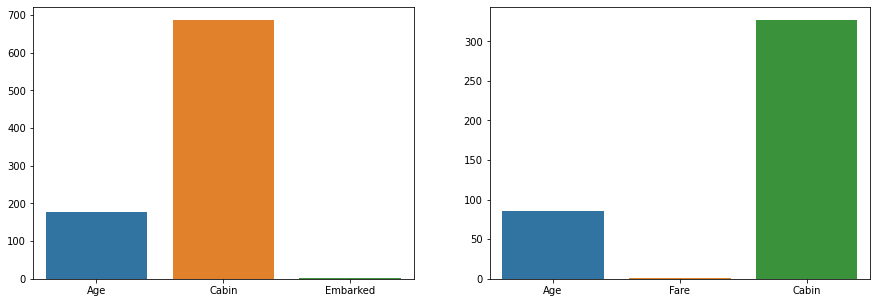

In [3]:
null_train = train.isnull().sum()[train.isnull().sum()>0]
null_test = test.isnull().sum()[test.isnull().sum()>0]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=null_train.index, y=null_train)
plt.subplot(1,2,2)
sns.barplot(x=null_test.index, y=null_test)
plt.show()

In [4]:
#Filling Age
train['Age'] = train.Age.fillna(train.Age.mean())
test['Age'] = test.Age.fillna(test.Age.mean())

#Filling Cabin
train['Cabin'] = train['Cabin'].fillna(0)
test['Cabin'] = test['Cabin'].fillna(0)

#Filling Embarked
train.loc[train.Embarked.isna(),'Embarked'] = train.Embarked.mode()[0]

#Filling Fare (Test)
test.loc[test.Fare.isna(),'Fare'] = train.Fare.mean()

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


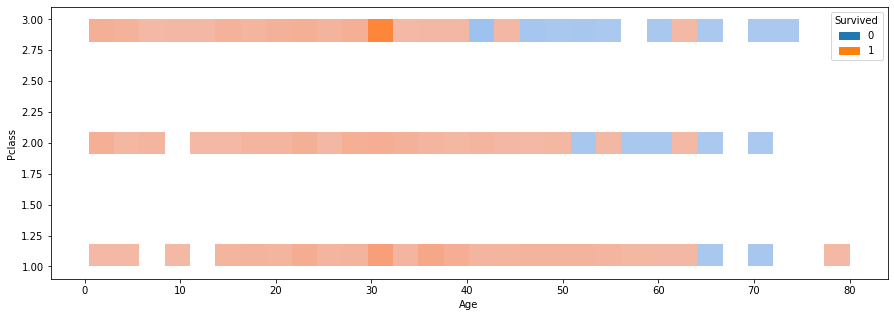

In [6]:
plt.figure(figsize=(15,5))
sns.histplot(data=train, x='Age', hue='Survived', y='Pclass')
plt.show()

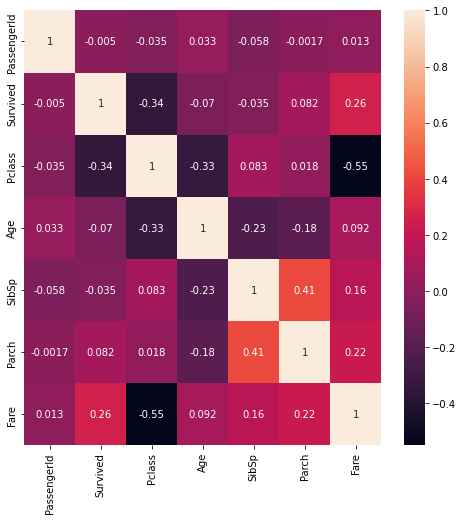

In [7]:
# train = train.drop(columns='PassengerId')
corr = train.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)
plt.show()

## Feature Engineering 
#### 1. Simplify Sex, Embarked Feature and Cabin

In [8]:
for i in full:
    #Sex, Male:0, Female:1
    i['Sex'] = i.Sex.replace(dict(male=2, female=1))
    
    #Embarked, S:0, C:1, Q:2
    i['Embarked'] = i.Embarked.replace(dict(S=1, C=2, Q=3))
    
    #Cabin, 0:0, str:1
    i['HasCabin'] = i.Cabin.apply(lambda x : 1 if isinstance(x, str) else 0)

### 2. Binning Age and Fare

In [9]:
for i in full:
    #Age
    i.loc[i['Age'] <= 2, 'Age'] = 0
    i.loc[(i['Age'] > 2) & (i['Age'] <= 16), 'Age'] = 1
    i.loc[(i['Age'] > 16) & (i['Age'] <= 60), 'Age'] = 2
    i.loc[(i['Age'] > 60), 'Age'] = 3
 
    #Fare
    i.loc[(i['Fare']<= 8), 'Fare'] = 0
    i.loc[(i['Fare'] > 8) & (i['Fare'] <= 14.5), 'Fare'] = 1
    i.loc[(i['Fare'] > 14.5) & (i['Fare'] <= 31), 'Fare'] = 2
    i.loc[i['Fare'] >31, 'Fare'] = 3

#### 3. Extracting Prefix and Ticket Type

In [10]:
def prefix(name):
    prefix_search = re.search(' ([A-Za-z]+)\.', name)
    if prefix_search:
        return prefix_search.group(1)
    return ""

In [11]:
for i in full:
    #Extract Prefix
    i['Prefix'] = i.Name.apply(prefix)
    
    i['Prefix'] = i.Prefix.replace(dict(Mr=1, 
                                        Mrs=2, 
                                        Miss=3, Mme=3, Ms=3,
                                        Master=4,
                                        Don=5, Rev=5, Major=5, Lady=5, Sir=5, Millie=5, Col=5, Capt=5,
                                        Countess=5, Jonkheer=5, Dr=5, Mlle=5, Dona=5))
#     #Extract Ticket Type
#     i['Ticket_type'] = i['Ticket'].apply(lambda x: x[0:3])
#     i['Ticket_type'] = i['Ticket_type'].astype('category')
#     i['Ticket_type'] = i['Ticket_type'].cat.codes

#### 4. Creating New Features

In [12]:
for i in full:
    #Family Size
    i['FamilySize'] = i['SibSp'] + i['Parch'] + 1

    #Alone
    i['Alone'] = 0
    i.loc[i['FamilySize'] ==1, 'Alone'] = 1

In [13]:
y = train['Survived']
# df_train = train.drop(columns='Survived')
df_train = train
drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_train = df_train.drop(columns=drop)
df_test = test.drop(columns=drop)

In [14]:
# for col in ['Sex', 'HasCabin', 'Embarked']:
#     df_train[col] = df_train[col].astype('category')
#     df_test[col] = df_test[col].astype('category')

for col in ['Age', 'Fare']:
    df_train[col] = df_train[col].astype('int64')
    df_test[col] = df_test[col].astype('int64')
    
for col in ['SibSp', 'Parch']:
    df_train = df_train.drop(columns=col)
    df_test = df_test.drop(columns=col)

In [15]:
df_train.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age           int64
Fare          int64
Embarked      int64
HasCabin      int64
Prefix        int64
FamilySize    int64
Alone         int64
dtype: object

In [16]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,HasCabin,Prefix,FamilySize,Alone
0,3,2,2,0,3,0,1,1,1
1,3,1,2,0,1,0,2,2,0
2,2,2,3,1,3,0,1,1,1
3,3,2,2,1,1,0,1,1,1
4,3,1,2,1,1,0,2,3,0


## Heat Map

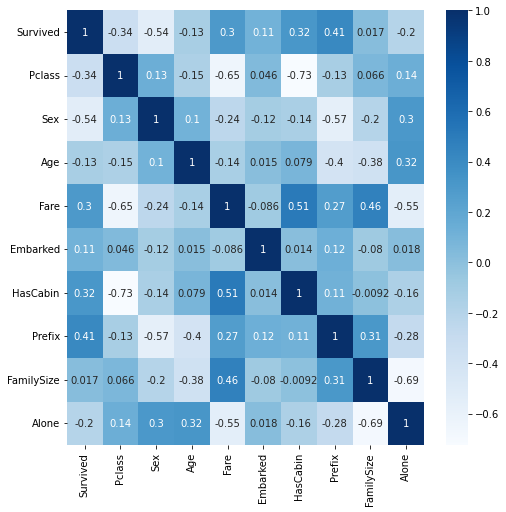

In [17]:
plt.figure(figsize=(8,8))
corr = df_train.corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

In [18]:
df_train = df_train.drop(columns='Survived')

## Model 

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.2, random_state=11)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (712, 9)
X_val shape: (179, 9)
y_train shape: (712,)
y_val shape: (179,)


In [20]:
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_val = stdsc.transform(X_val)

In [21]:
def get_models():
    models = list()
    models.append(('xgb', XGBClassifier(n_estimators= 1000,
                                      max_depth= 4,
                                      min_child_weight= 2,
                                      gamma=0.9,                        
                                      subsample=0.5,
                                      colsample_bytree=1,
                                      objective= 'binary:logistic',
                                      nthread= -1,
                                      use_label_encoder=False,
                                      eval_metric='error')))
    
    models.append(('rt', RandomForestClassifier(n_estimators=1000,
                                    criterion='entropy',
                                    max_depth=9,
                                    max_samples=0.7,
                                    )))
    
    models.append(('lightgbm', LGBMClassifier(n_estimators=1000,
                                             learning_rate=0.03,
                                             objective='binary',
                                             num_leaves=10,
                                             subsample = 0.7,
                        #                      subsample_freq=9,
                                             reg_lambda=1,
                                             reg_alpha=0.3,
                                            )))
    models.append(('bayes', GaussianNB()))
    return models

In [22]:
def fit_ensemble(models):
    meta_x = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat),1)
        meta_x.append(yhat)
          
    meta_x = np.hstack(meta_x)
    blender = StackingClassifier(estimators=models,
                                 final_estimator=models[0][1])
    
    blender.fit(meta_x, y_val)
    
    return models, blender

In [23]:
def predict_ensemble(blender, models, X, coeff):
    meta_x = list()
    for name, model in models:
        yhat = model.predict(X)
        yhat = yhat.reshape(len(yhat),1)
        meta_x.append(yhat)
    blend_predict = blender.predict(np.hstack(meta_x))
    blend_predict = blend_predict.reshape(len(blend_predict),1)
    
    meta_x.append(blend_predict)
    meta_x = np.hstack(meta_x)
    prediction = meta_x * coeff
    prediction = np.sum(prediction, axis=1)
#     print(prediction)
    prediction[prediction>=0.5] = 1
    prediction[prediction<0.5] = 0
    return prediction

In [24]:
models = get_models()

In [25]:
models, blender = fit_ensemble(models)

In [26]:
for name, model in models:
    print(f'Model: {name}')
    print(f'Training Accuracy: {accuracy_score(model.predict(X_train), y_train)}')
    print(f'Validation Accuracy: {accuracy_score(model.predict(X_val), y_val)}')
    print('---------------------------------------')

Model: xgb
Training Accuracy: 0.8637640449438202
Validation Accuracy: 0.9050279329608939
---------------------------------------
Model: rt
Training Accuracy: 0.875
Validation Accuracy: 0.8715083798882681
---------------------------------------
Model: lightgbm
Training Accuracy: 0.851123595505618
Validation Accuracy: 0.8715083798882681
---------------------------------------
Model: bayes
Training Accuracy: 0.7780898876404494
Validation Accuracy: 0.8100558659217877
---------------------------------------


In [27]:
coeff = np.array([0.2, 0.2, 0.2, 0.2, 0.1])
prediction = predict_ensemble(blender, models, X_train, coeff)

print(f'Model: Stack')
print(f'Training Accuracy: {accuracy_score(predict_ensemble(blender, models, X_train, coeff), y_train)}')
print(f'Validation Accuracy: {accuracy_score(predict_ensemble(blender, models, X_val, coeff), y_val)}')
print('---------------------------------------')

Model: Stack
Training Accuracy: 0.8595505617977528
Validation Accuracy: 0.9050279329608939
---------------------------------------


## Submission

In [28]:
X_test = stdsc.fit_transform(df_test)

In [29]:
prediction = predict_ensemble(blender, models, X_test, coeff)
prediction = prediction.reshape(len(prediction),1)

In [30]:
p = pd.DataFrame(prediction.astype('int64'), columns=['Survived'])

In [31]:
submission = pd.concat([test.PassengerId, p], axis=1)

In [32]:
submission.to_csv('submission_v12.csv', index=False)

In [33]:
pd.read_csv('submission_v12.csv').head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
